In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf
from statsmodels.stats import multitest
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

# MOP peripheral

In [23]:
mop_periph_df = pd.read_csv('../outputs/gene_ontology/MOp_periphal_ReadZs_10X_gene_ontology.csv')
mop_periph_df['Mouse'] = 'Mouse '+mop_periph_df['sample_id'].str[1]
mop_periph_df['Slice'] = 'Slice '+mop_periph_df['sample_id'].str[3]
mop_periph_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Mouse,Slice
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293,Mouse 1,Slice 1
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769,Mouse 1,Slice 1
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015,Mouse 1,Slice 1
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833,Mouse 1,Slice 1
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449,Mouse 1,Slice 1


In [32]:
mop_periph_gene_ont = mop_periph_df[
    mop_periph_df['bh_p'].le(0.05) #has to be significant
].groupby(['gene','ontology']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

mop_periph_hits = mop_periph_gene_ont[
    mop_periph_gene_ont['num_samples'].ge(2) & #has to be present in x or more samples
    mop_periph_gene_ont['med_cells'].ge(25) #with a median of 20 or more cells
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0 #has to have a negative and positive score
)

print(mop_periph_hits.reset_index()['gene'].nunique())
print(mop_periph_hits.reset_index()['gene'].eq('Timp3').any())
mop_periph_hits

46
True


num_samples  med_cells  mean_ont_score  std_ont_score
gene    ontology                                                       
Adamts4 L6 CT               2       28.0        0.234297       0.036275
        Oligo              12     1170.0       -0.053112       0.024923
Calb2   L2/3 IT             9      244.0       -0.324164       0.066223
        L5 IT               3       26.0       -0.329205       0.066244
        L6 IT               4       28.5       -0.285976       0.081086
...                       ...        ...             ...            ...
Wipf3   Lamp5               3       81.0        0.094322       0.079086
        OPC                 3       26.0        0.194964       0.025920
        Oligo              11       31.0        0.299652       0.085031
        Pvalb               5      454.0       -0.049208       0.011377
        Sst                 2      150.0       -0.061005       0.006977

[250 rows x 4 columns]

In [38]:
gene_ont_meds = mop_periph_df.groupby(['gene','ontology'])['med_score'].median().reset_index()
gene_ont_meds

,gene,ontology,med_score
0,Acta2,L2/3 IT,0.103641
1,Acta2,L5 ET,0.032479
2,Acta2,L5 IT,0.116424
3,Acta2,L6 CT,0.176217
4,Acta2,L6 IT,0.189794
...,...,...,...
1365,Wnt7b,OPC,0.090610
1366,Zfp804b,L5 ET,-0.229299
1367,Zfp804b,L6 CT,-0.151163
1368,Zfp804b,L6 IT,-0.376531


In [51]:
q = gene_ont_meds[gene_ont_meds['gene'].isin(genes)].groupby('gene').agg(
    min_med = ('med_score','min'),
    max_med = ('med_score','max'),
)
q['span'] = q['max_med']-q['min_med']
q = q.sort_values('span',ascending=False).reset_index().reset_index()
q[q['gene'].isin(['Dscaml1','Timp3'])]

,index,gene,min_med,max_med,span
8,8,Timp3,-0.015436,0.436893,0.452329
22,22,Dscaml1,-0.229975,0.021074,0.251049


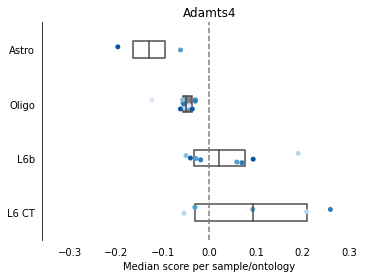

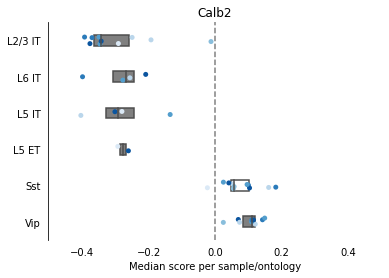

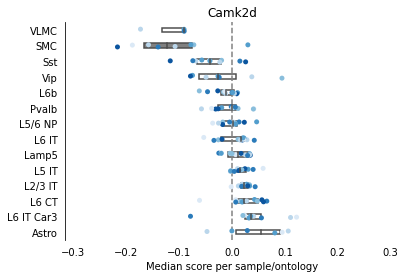

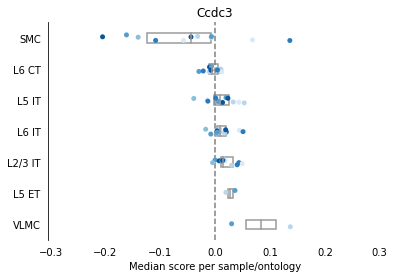

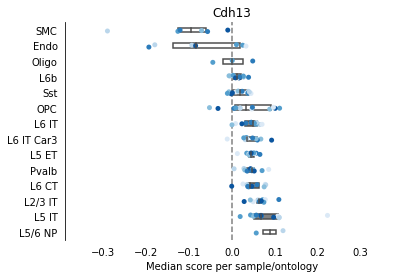

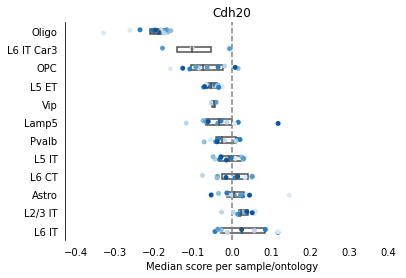

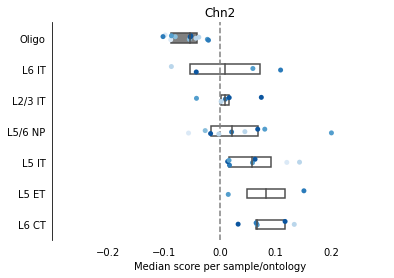

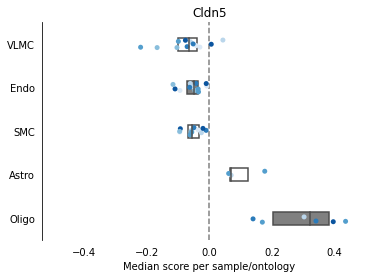

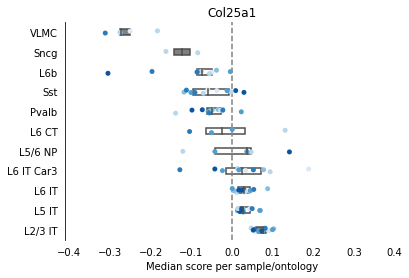

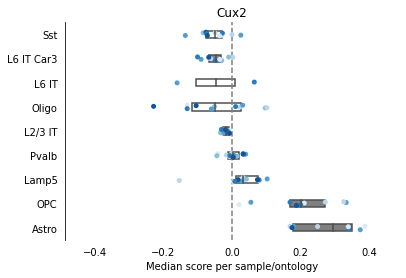

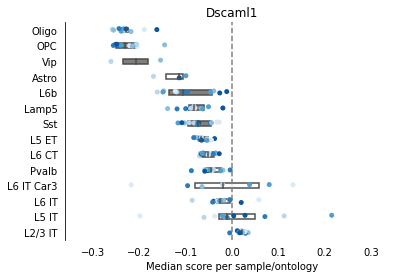

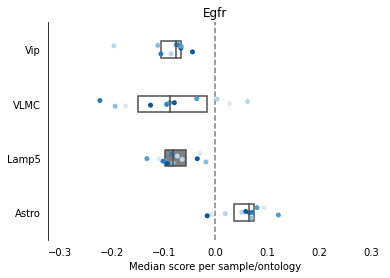

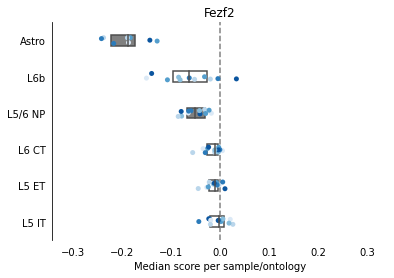

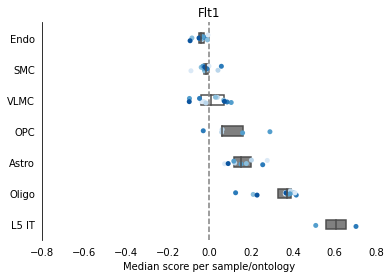

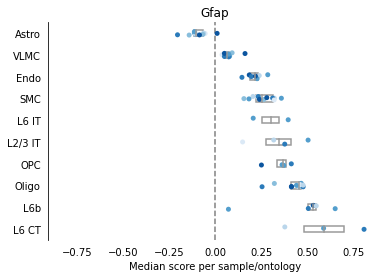

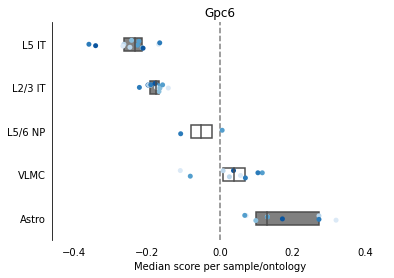

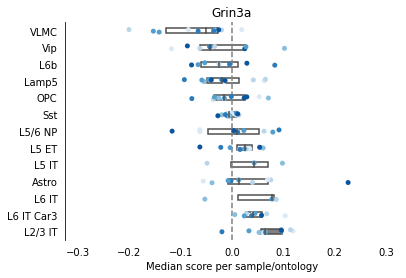

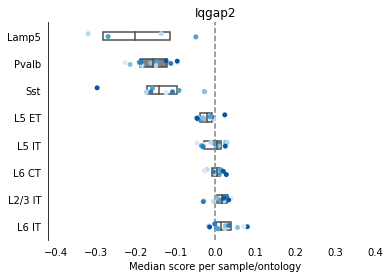

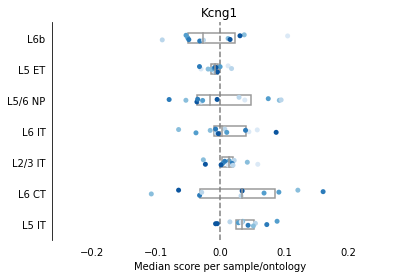

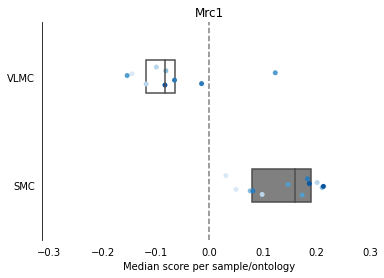

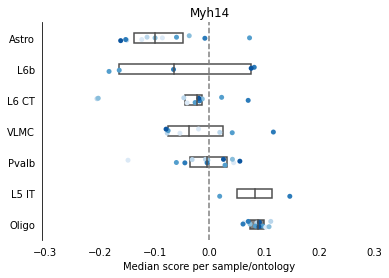

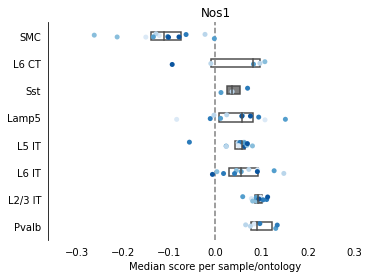

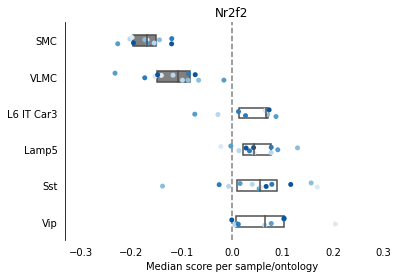

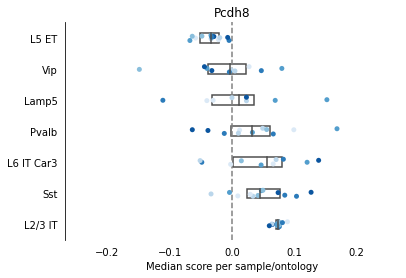

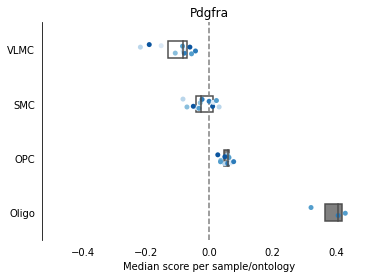

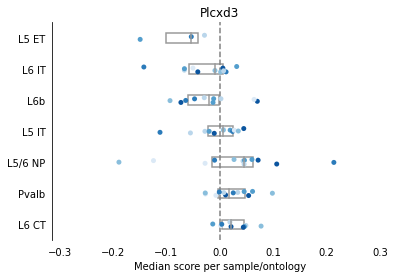

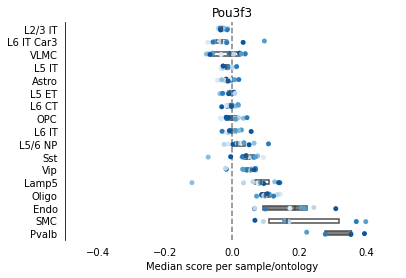

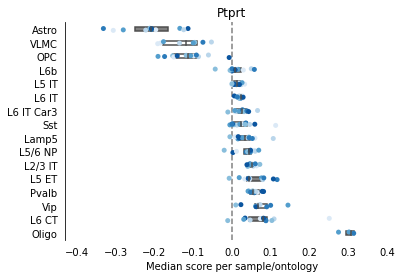

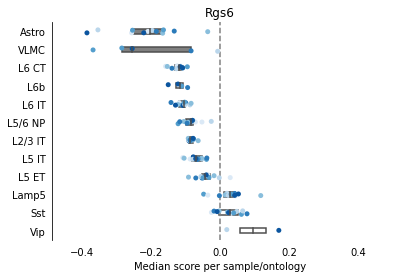

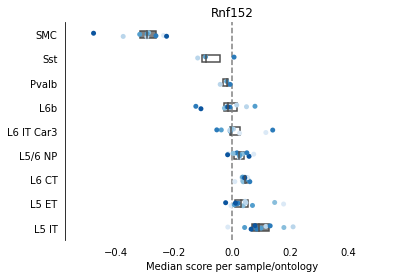

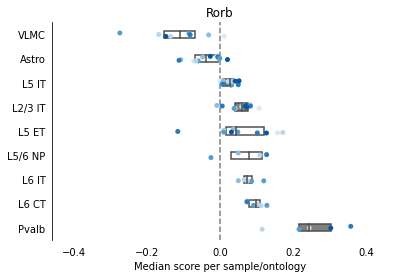

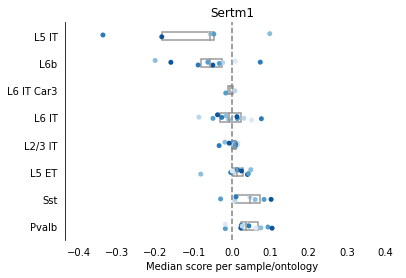

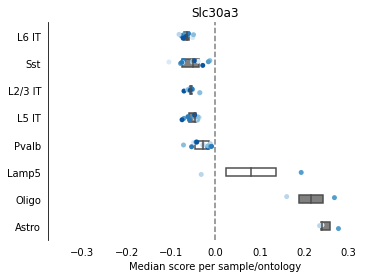

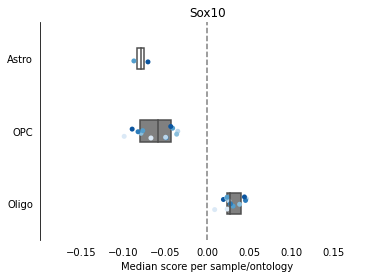

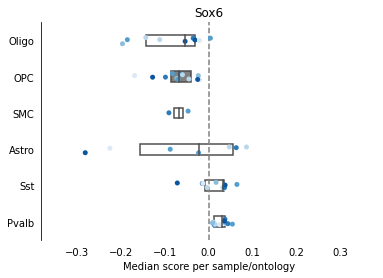

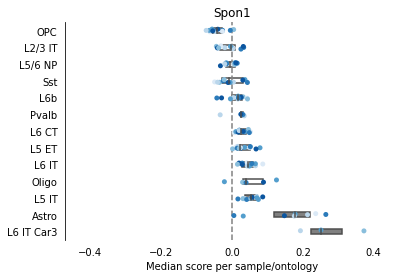

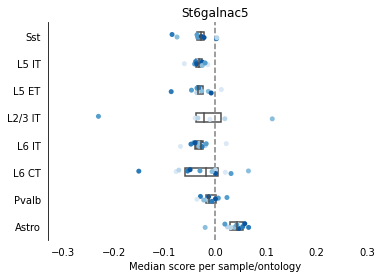

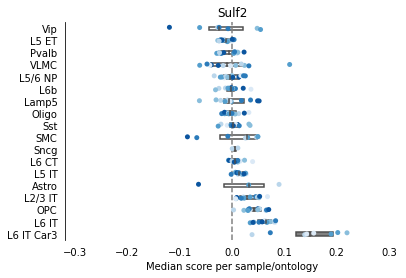

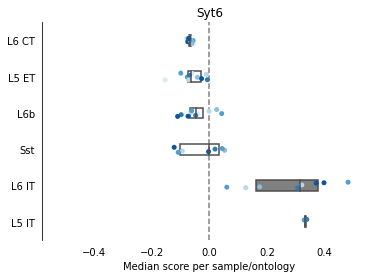

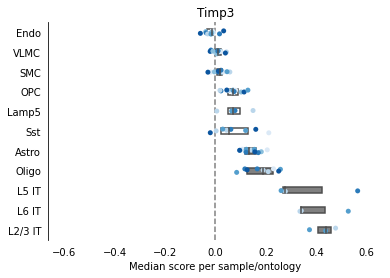

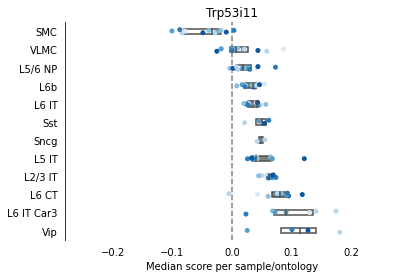

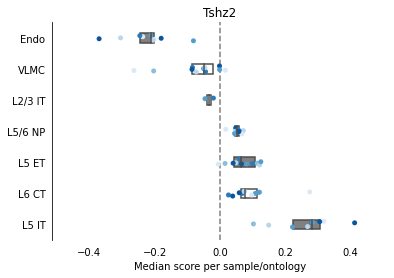

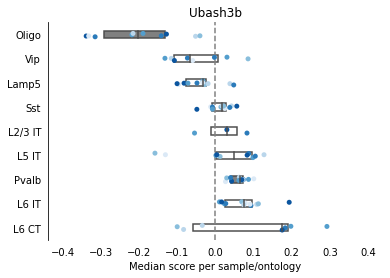

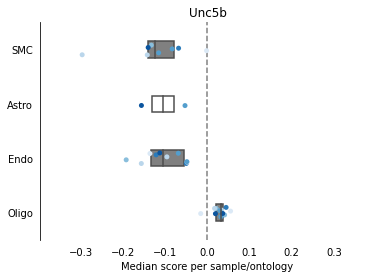

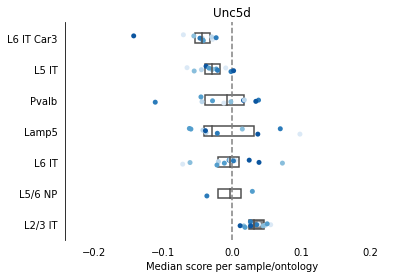

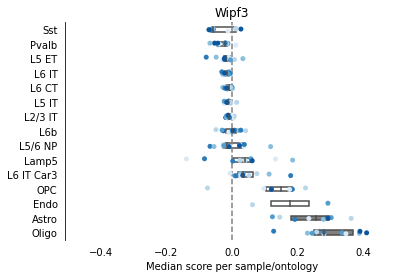

In [33]:
# simplified diagram for a single gene
genes = list(mop_periph_hits.reset_index()['gene'].unique())
#genes.append('Timp3') #especially interested in this

#pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_MOp_peripheral_differential_genes.pdf')

for gene in genes:

    plot_df = mop_periph_df[mop_periph_df['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 2) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['significant'] = plot_df.groupby('ontology')['bh_p'].transform(lambda v: np.median(v) < 0.05)
    ont_order = plot_df.groupby('ontology')['med_score'].mean().sort_values().index
    

    ax = sns.stripplot(
        x = 'med_score',
        y = 'ontology',
        order = ont_order,
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'med_score',
        y = 'ontology',
        hue = 'significant',
        palette = ['white','grey'],
        order = ont_order,
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    #plt.axvspan(0,plot_df['med_score'].max(),facecolor='#eeeeee',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Median score per sample/ontology')
    plt.ylabel('')
    x_lim = max(np.abs(plot_df['med_score'].min()),np.abs(plot_df['med_score'].max()))
    x_lim = min(1,x_lim+0.1)
    plt.xlim(-x_lim,x_lim)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend([],[], frameon=False) #remove legend
    plt.show()
    plt.tight_layout()
    #pdf.savefig()
    plt.close()
    
    
#pdf.close()

In [5]:
plot_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Mouse,Slice,mouse,sample,significant
644,m1s1,Timp3,Astro,373,9.0,154.0,0.106383,30.445873,31.042940,5.464457,4.643260e-08,2.578596e-07,Mouse 1,Slice 1,Mouse 1,Sample 1,True
645,m1s1,Timp3,Endo,217,10.0,157.0,-0.012739,-2.733071,16.641938,-0.669960,5.028832e-01,6.086284e-01,Mouse 1,Slice 1,Mouse 1,Sample 1,False
646,m1s1,Timp3,OPC,62,6.0,281.5,0.070838,3.733347,6.573045,1.456180,1.453429e-01,2.300449e-01,Mouse 1,Slice 1,Mouse 1,Sample 1,False
647,m1s1,Timp3,SMC,229,17.0,254.0,-0.019565,-4.283907,12.323907,-1.220298,2.223520e-01,3.235740e-01,Mouse 1,Slice 1,Mouse 1,Sample 1,False
648,m1s1,Timp3,Sst,25,7.0,485.0,0.211538,4.563216,2.390533,2.951370,3.163680e-03,8.303132e-03,Mouse 1,Slice 1,Mouse 1,Sample 1,False


In [6]:
plot_df['ontology'].nunique()

11

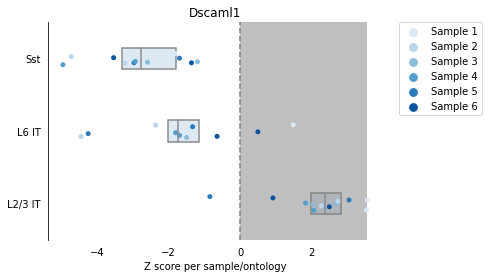

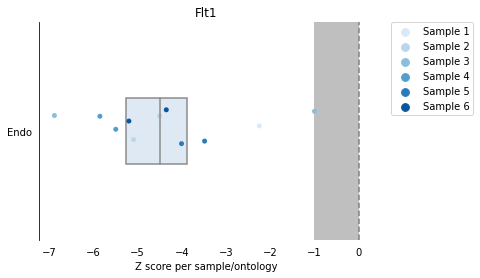

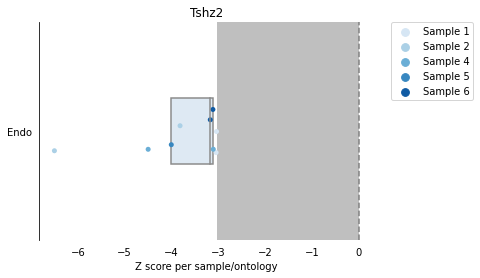

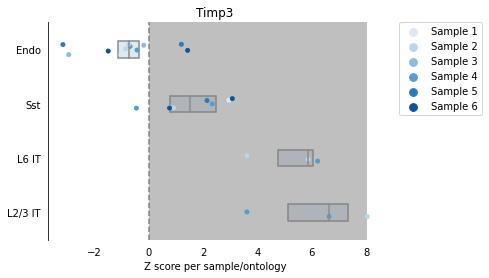

In [15]:
genes = ['Dscaml1', 'Flt1', 'Tshz2', 'Timp3']
onts = ['L6 IT','L2/3 IT','Sst','Endo']

for gene in genes:
    plot_df = mop_periph_df[
        mop_periph_df['gene'].eq(gene) &
        mop_periph_df['ontology'].isin(onts)
    ].copy()
    
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.tight_layout()
    #plt.savefig('{}_MOp_periph_boxplot.svg'.format(gene))
    plt.close()
    

In [12]:
plot_df.groupby('ontology')['med_score'].mean().sort_values()

ontology
Endo      -0.016746
VLMC       0.009727
SMC        0.015789
OPC        0.070498
Lamp5      0.074057
Sst        0.075867
Astro      0.139269
Oligo      0.180963
L5 IT      0.367198
L6 IT      0.400755
L2/3 IT    0.428757
Name: med_score, dtype: float64

# MOP Radial

In [32]:
mop_radial_df = pd.read_csv('../outputs/gene_ontology/MOp_radial_ReadZs_gene_ontology.csv')
mop_radial_df['Mouse'] = 'Mouse '+mop_radial_df['sample_id'].str[1]
mop_radial_df['Slice'] = 'Slice '+mop_radial_df['sample_id'].str[3]
mop_radial_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Mouse,Slice
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.069892,26.390894,46.958252,3.851218,0.000118,0.000387,Mouse 1,Slice 1
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.051064,4.249919,6.067670,1.725320,0.084470,0.146937,Mouse 1,Slice 1
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.055679,12.965918,29.188310,2.399931,0.016398,0.035691,Mouse 1,Slice 1
3,m1s1,Acta2,L6 CT,26,5.0,304.0,-0.197255,-4.178031,3.271222,-2.310025,0.020887,0.044275,Mouse 1,Slice 1
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.091278,4.741353,10.194193,1.484998,0.137544,0.220147,Mouse 1,Slice 1


In [33]:
mop_radial_gene_ont = mop_radial_df[
    mop_radial_df['bh_p'].le(0.05)
].groupby(['gene','ontology']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

mop_radial_hits = mop_radial_gene_ont[
    mop_radial_gene_ont['num_samples'].ge(6) &
    mop_radial_gene_ont['med_cells'].ge(20)
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0
)

mop_radial_hits

num_samples  med_cells  mean_ont_score  std_ont_score
gene    ontology                                                       
Ano4    L5 IT               8      178.0        0.086484       0.026575
        L6 CT               6     1197.0       -0.052429       0.011424
        L6 IT               8      171.5        0.076308       0.030199
        Oligo              12      838.0       -0.118764       0.025314
Aqp4    Astro              12      721.0       -0.284972       0.019689
...                       ...        ...             ...            ...
Ubash3b Pvalb              12      433.5       -0.126541       0.017686
        Sst                 8      182.0       -0.087128       0.022763
Vtn     Endo                7       24.0        0.233354       0.058442
        SMC                12      169.5       -0.129088       0.022279
        VLMC               12      279.0       -0.137769       0.027737

[91 rows x 4 columns]

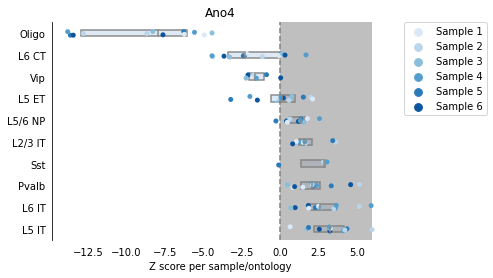

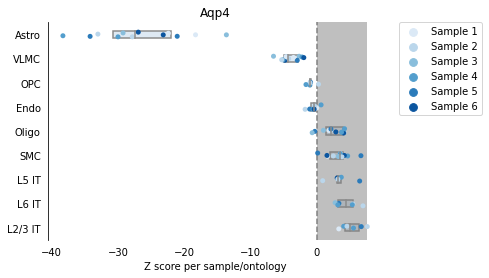

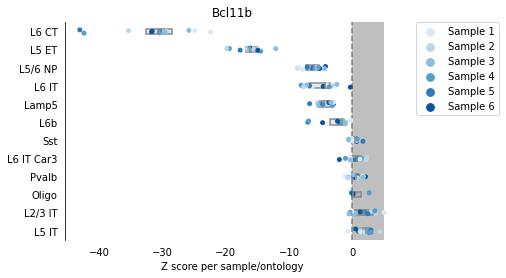

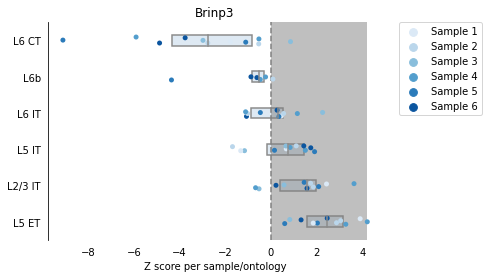

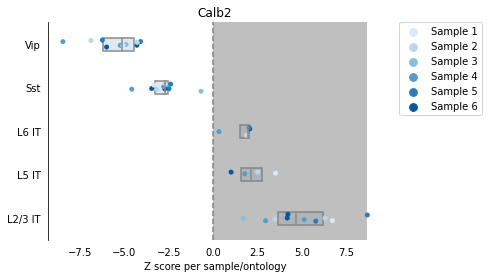

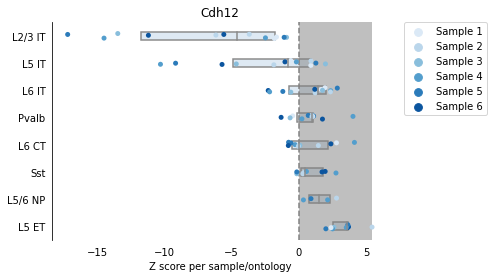

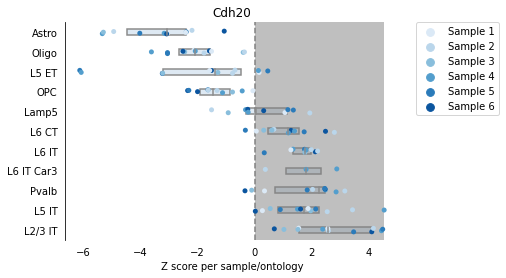

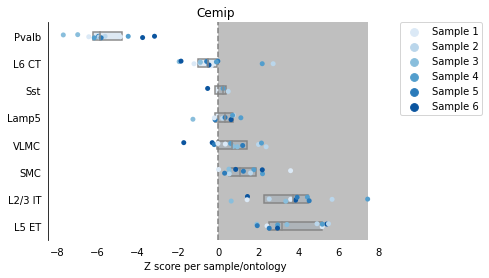

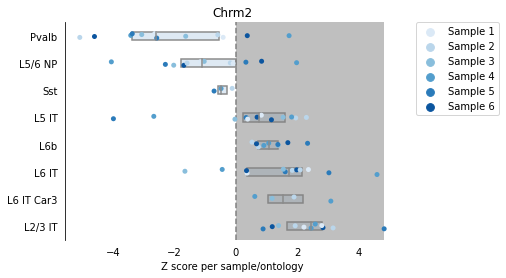

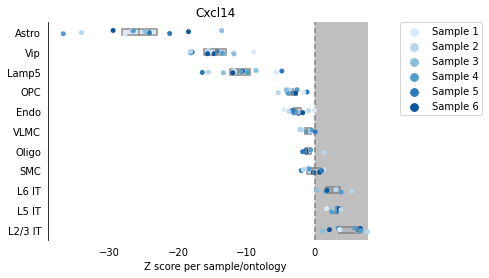

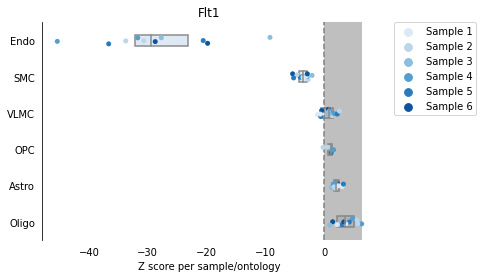

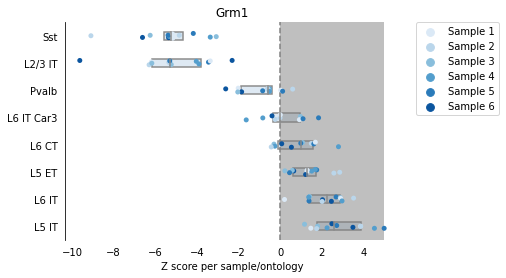

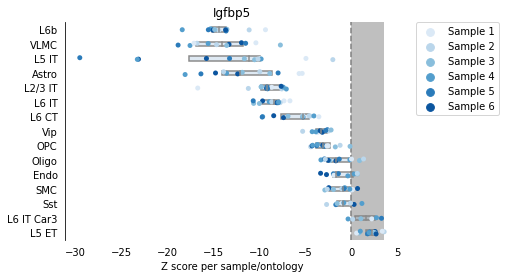

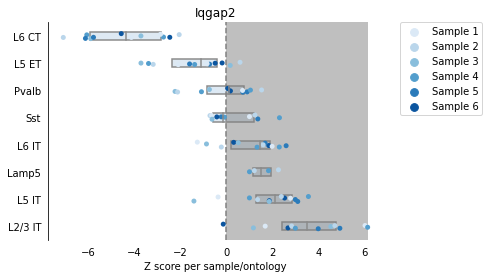

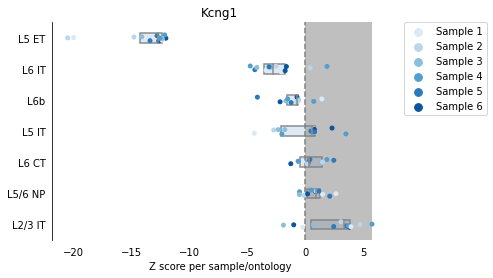

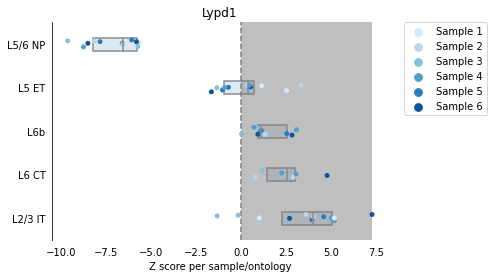

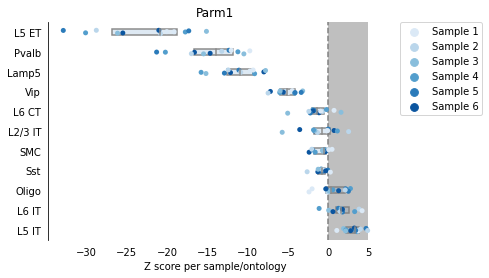

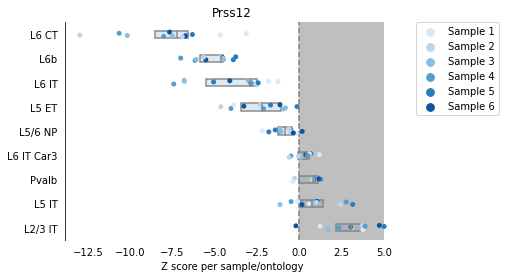

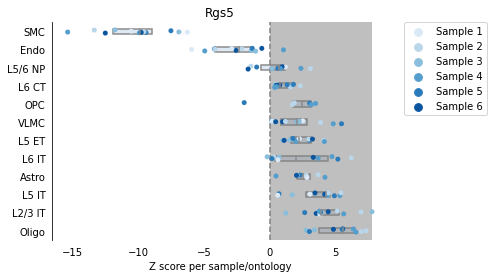

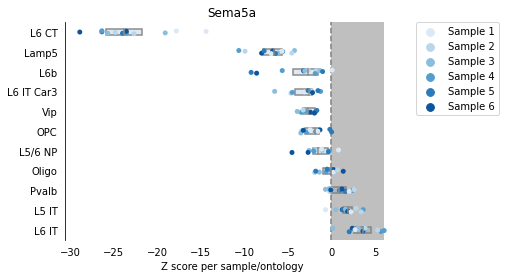

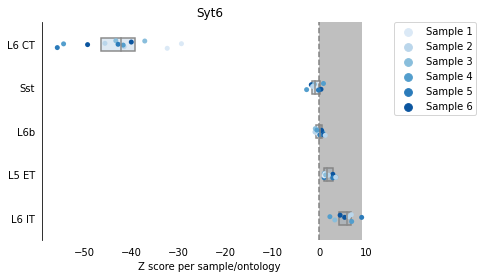

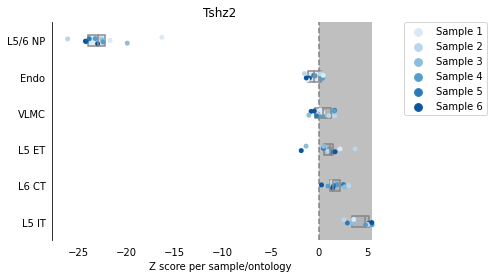

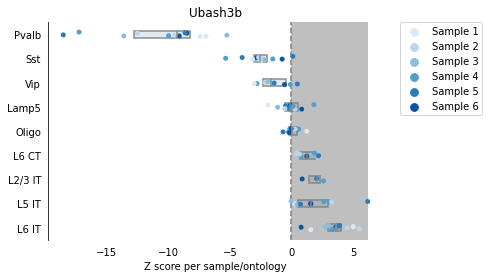

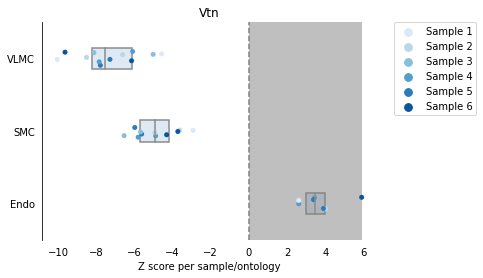

In [34]:
# simplified diagram for a single gene
genes = mop_radial_hits.reset_index()['gene'].unique()

pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_MOp_radial_differential_genes.pdf')

for gene in genes:

    plot_df = mop_radial_df[mop_radial_df['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.tight_layout()
    #pdf.savefig()
    plt.close()
    
pdf.close()

In [40]:
genes = ['Vtn', 'Calb2', 'Cemip']

for gene in genes:
    plot_df = mop_radial_df[mop_radial_df['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    plt.savefig('{}_MOp_radial_boxplot.svg'.format(gene))
    plt.close()
    

# MOP punctate

In [2]:
mop_punctate_df = pd.read_csv('../outputs/gene_ontology/MOp_punctate_10X_ontology.csv')
mop_punctate_df['Mouse'] = 'Mouse '+mop_punctate_df['sample_id'].str[1]
mop_punctate_df['Slice'] = 'Slice '+mop_punctate_df['sample_id'].str[3]
mop_punctate_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Mouse,Slice
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,-0.001414,-2.967144,46.958252,-0.432995,0.665019,0.730818,Mouse 1,Slice 1
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.055954,-1.032529,6.067670,-0.419171,0.675091,0.739282,Mouse 1,Slice 1
2,m1s1,Acta2,L5 IT,257,6.0,654.0,-0.051460,-16.400076,29.188310,-3.035578,0.002401,0.004913,Mouse 1,Slice 1
3,m1s1,Acta2,L6 CT,26,5.0,304.0,-0.280067,-6.332081,3.271222,-3.500995,0.000464,0.001055,Mouse 1,Slice 1
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.090909,2.450220,10.194193,0.767412,0.442836,0.527382,Mouse 1,Slice 1


In [3]:
mop_puncate_gene_ont = mop_punctate_df[
    mop_punctate_df['bh_p'].le(0.05)
].groupby(['gene','ontology']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

mop_punctate_hits = mop_puncate_gene_ont[
    mop_puncate_gene_ont['num_samples'].ge(6) &
    mop_puncate_gene_ont['med_cells'].ge(20)
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0
)

mop_punctate_hits

num_samples  med_cells  mean_ont_score  std_ont_score
gene  ontology                                                       
Calb2 L2/3 IT            10      236.5        0.350328       0.047939
      Sst                11       31.0       -0.184414       0.053994
      Vip                10       28.5       -0.299898       0.033866
Cdh12 L2/3 IT             8     1891.5       -0.069175       0.030884
      L5 ET               7      217.0        0.101139       0.032418
...                     ...        ...             ...            ...
Ust   L2/3 IT             6      188.5        0.097132       0.037778
      L5 ET               9      407.0       -0.073279       0.024158
Vtn   Endo                7       24.0        0.227632       0.072266
      SMC                12      169.5       -0.154035       0.029302
      VLMC               12      279.0       -0.165955       0.029964

[87 rows x 4 columns]

In [18]:
len(mop_punctate_hits.reset_index()['gene'].unique())

25

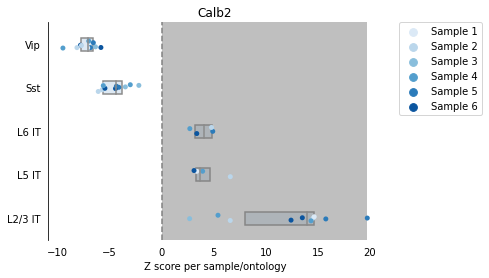

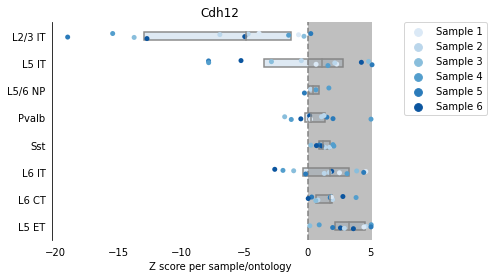

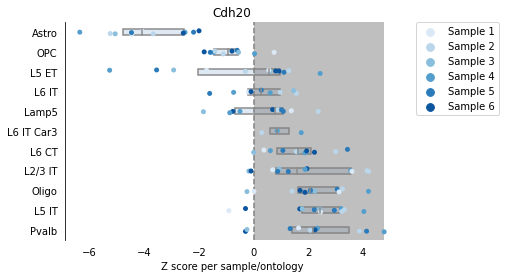

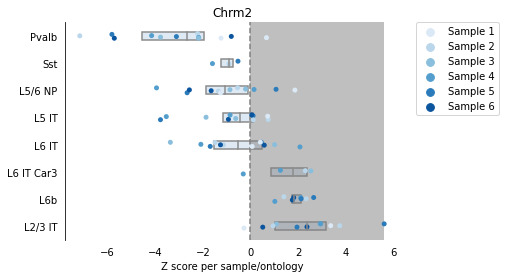

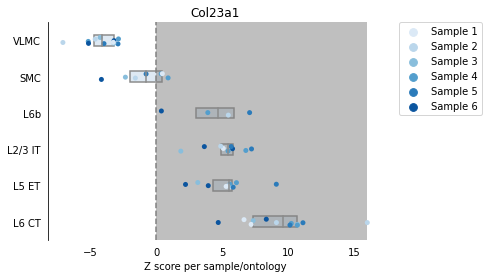

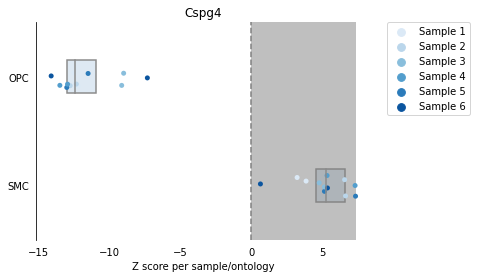

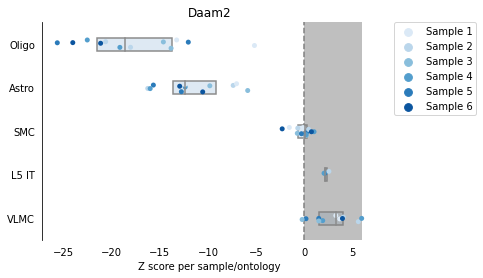

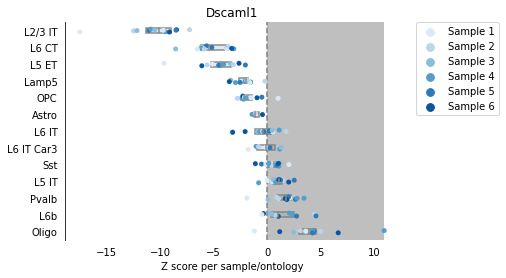

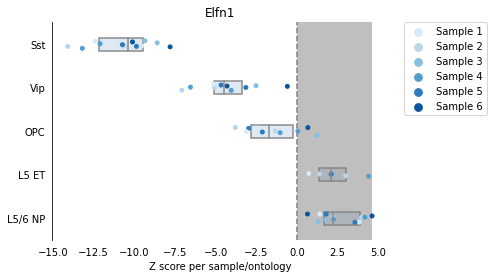

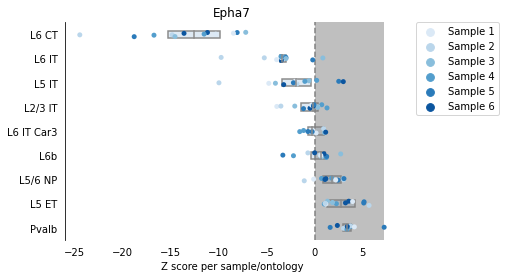

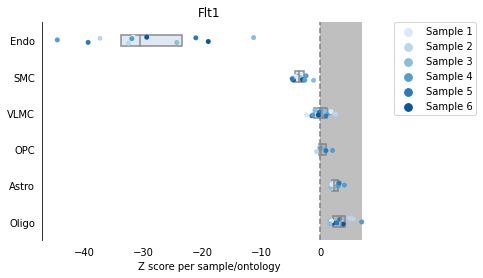

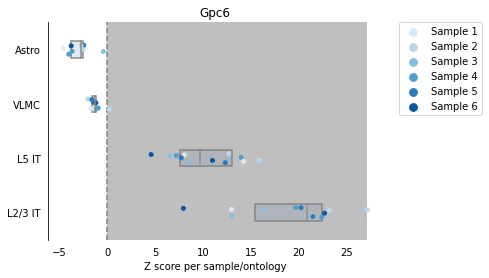

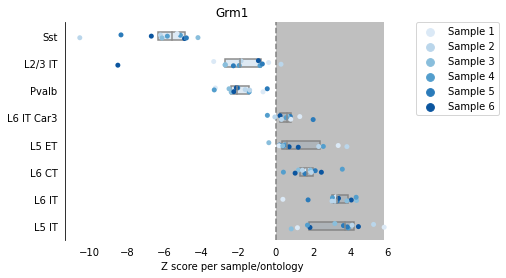

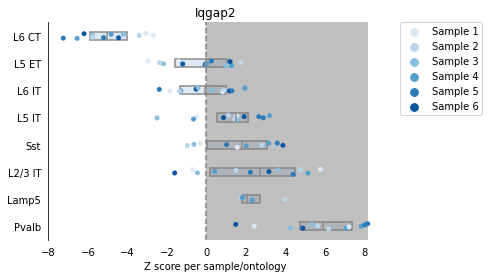

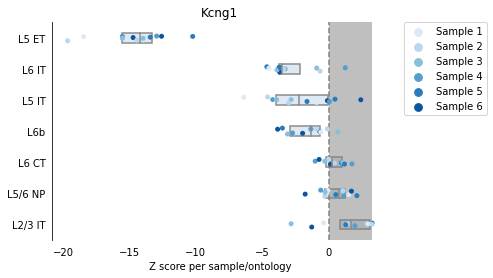

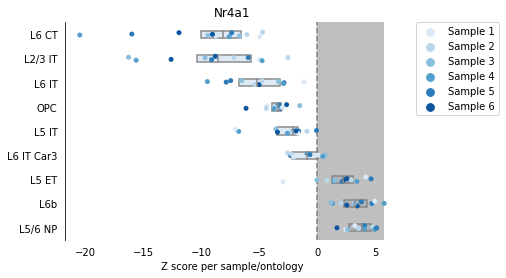

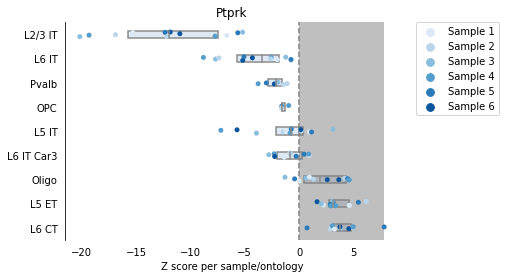

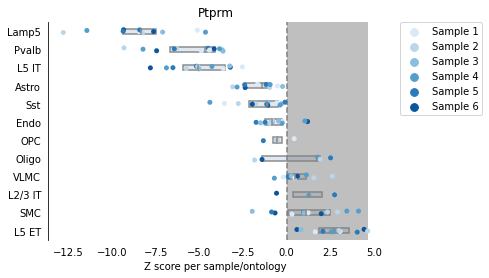

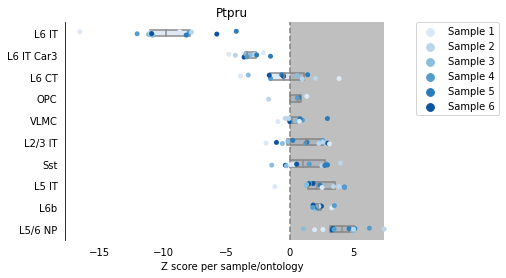

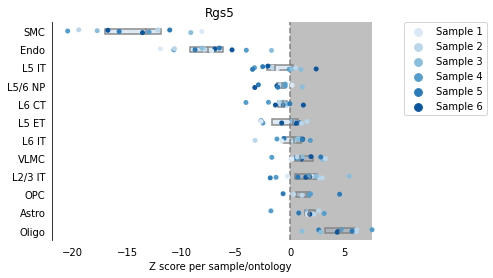

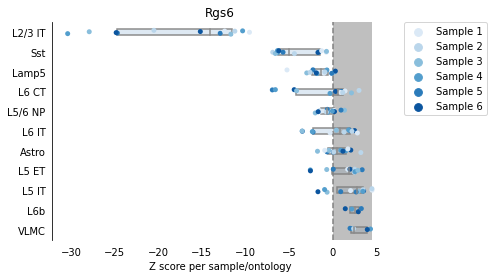

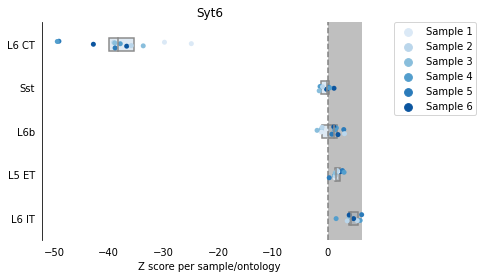

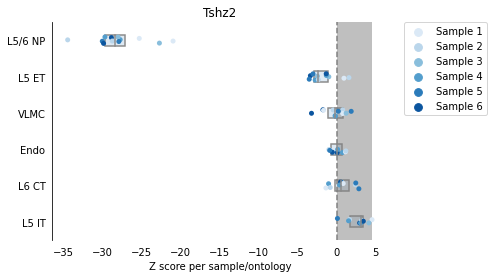

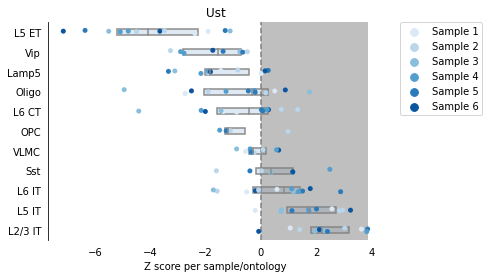

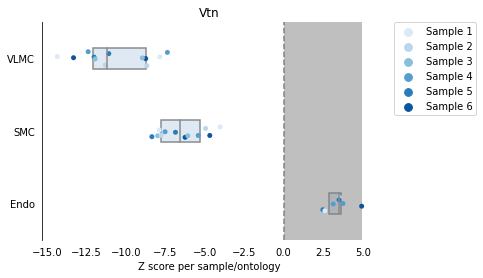

In [5]:
# simplified diagram for a single gene
genes = mop_punctate_hits.reset_index()['gene'].unique()

pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_MOp_punctate_differential_genes.pdf')

for gene in genes:

    plot_df = mop_punctate_df[mop_punctate_df['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.tight_layout()
    #pdf.savefig()
    plt.close()
    
pdf.close()

In [6]:
genes = ['Cdh20', 'Chrm2', 'Ust']

for gene in genes:
    plot_df = mop_punctate_df[mop_punctate_df['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'ontology',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    plt.savefig('{}_MOp_punctate_boxplot.svg'.format(gene))
    plt.close()
    

# Brainmap Peripheral

In [60]:
viz_periph_df = pd.read_csv('../outputs/gene_ontology/Vizgen_Brainmap_peripheral.csv')
viz_periph_df['Slice'] = 'Slice '+viz_periph_df['sample_id'].str[1]
viz_periph_df['Replicate'] = 'Replicate '+viz_periph_df['sample_id'].str[3]
viz_periph_df.head()

,sample_id,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Slice,Replicate
0,s1r1,Abcc9,14,20,10.0,880.0,-0.056263,-0.984834,1.544349,-0.792483,0.428079,0.504933,Slice 1,Replicate 1
1,s1r1,Ackr1,0,430,10.5,993.5,0.009465,0.330981,33.477725,0.057204,0.954383,0.965548,Slice 1,Replicate 1
2,s1r1,Ackr1,1,443,13.0,948.0,-0.019802,-9.590985,30.814218,-1.727777,0.084028,0.122993,Slice 1,Replicate 1
3,s1r1,Ackr1,2,321,10.0,959.0,-0.034091,-8.687521,25.477803,-1.721135,0.085226,0.124497,Slice 1,Replicate 1
4,s1r1,Ackr1,3,273,8.0,1092.0,-0.023364,-5.742935,24.924740,-1.150320,0.250012,0.320098,Slice 1,Replicate 1


In [61]:
viz_periph_gene_ont = viz_periph_df[
    viz_periph_df['bh_p'].le(0.05)
].groupby(['gene','annotation']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

viz_periph_hits = viz_periph_gene_ont[
    viz_periph_gene_ont['num_samples'].ge(4) &
    viz_periph_gene_ont['med_cells'].ge(20)
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0
)

viz_periph_hits

num_samples  med_cells  mean_ont_score  std_ont_score
gene  annotation                                                       
Chrm3 1                     6      272.5       -0.046464       0.026342
      2                     4      201.0       -0.051202       0.019799
      3                     4      221.0       -0.061563       0.043824
      4                     4      216.5       -0.051958       0.018150
      5                     4      212.5        0.009336       0.052198
      6                     5      167.0       -0.045032       0.020649
      7                     4      253.0       -0.060027       0.020792
      13                    4      149.0       -0.066795       0.095058
      20                    4       45.5       -0.107233       0.047779
Drd1  0                     4      265.0        0.045735       0.076298
      2                     5      131.0       -0.054752       0.009475
      5                     6      100.5        0.003581       0.112258
      13                    6       74.0        0.084267       0.013450
      22                    5      122.0        0.124517       0.025694
Epha4 0                     7      405.0       -0.023352       0.044361
      1                     4      323.5       -0.047765       0.008483
      5                     4      280.5       -0.025608       0.040224
      13                    6      218.0       -0.033904       0.049981
      15                    4      149.0       -0.172731       0.077776
      19                    4      179.0       -0.039045       0.069347
      23                    4      160.0        0.000851       0.048849
Gjc3  3                     5       55.0        0.141600       0.219191
      6                     6      241.0       -0.146587       0.050872
Ntsr2 1                     5       46.0        0.186738       0.224022
      3                     5       28.0        0.317230       0.072960
      5                     5      100.0       -0.078993       0.395508
      6                     6       46.0        0.244538       0.168892
      7                     5       43.0        0.227874       0.052857
      11                    4       26.5        0.292118       0.116004

In [63]:
viz_periph_hits.reset_index()['gene'].nunique()

5

In [16]:
# simplified diagram for a single gene
genes = viz_periph_hits.reset_index()['gene'].unique()

pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_viz_peripheral_differential_genes.pdf')

for gene in genes:

    plot_df = viz_periph_df[viz_periph_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['annotation'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    fig = plt.figure(figsize=(5,8))
    
    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
pdf.close()

In [22]:
viz_periph_hits.reset_index()['gene'].unique()

array(['Chrm3', 'Drd1', 'Epha4', 'Gjc3', 'Ntsr2'], dtype=object)

In [26]:
viz_radial_hits.reset_index()['gene'].unique()

array(['Ackr1', 'Adgrl3', 'Adora1', 'Drd1', 'Epha6', 'Epha7', 'Ephb1',
       'Erbb4', 'Fzd3', 'Gad1', 'Gpr22', 'Gprc5b', 'Grm1', 'Grm3',
       'Igf1r', 'Insr', 'Ryk', 'Slc17a6', 'Slc32a1'], dtype=object)

In [30]:
genes = ['Chrm3','Epha4']

for gene in genes:
    plot_df = viz_periph_df[viz_periph_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['annotation'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    plt.savefig('{}_Viz_periph_boxplot.svg'.format(gene))
    plt.close()
    

# Brainmap radial

In [64]:
viz_radial_df = pd.read_csv('../outputs/gene_ontology/Vizgen_Brainmap_radial.csv')
viz_radial_df['Slice'] = 'Slice '+viz_radial_df['sample_id'].str[1]
viz_radial_df['Replicate'] = 'Replicate '+viz_radial_df['sample_id'].str[3]
viz_radial_df.head()

,sample_id,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Slice,Replicate
0,s1r1,Abcc9,14,20,10.0,880.0,0.244697,3.335148,1.544349,2.683752,7.280105e-03,2.278986e-02,Slice 1,Replicate 1
1,s1r1,Ackr1,0,430,10.5,993.5,0.000952,0.410696,33.477725,0.070981,9.434128e-01,9.623304e-01,Slice 1,Replicate 1
2,s1r1,Ackr1,1,443,13.0,948.0,-0.101079,-30.136191,30.814218,-5.428912,5.669869e-08,4.640707e-07,Slice 1,Replicate 1
3,s1r1,Ackr1,2,321,10.0,959.0,-0.049596,-8.577276,25.477803,-1.699293,8.926391e-02,1.709836e-01,Slice 1,Replicate 1
4,s1r1,Ackr1,3,273,8.0,1092.0,-0.003559,7.953157,24.924740,1.593031,1.111532e-01,2.018097e-01,Slice 1,Replicate 1


In [65]:
viz_radial_gene_ont = viz_radial_df[
    viz_radial_df['bh_p'].le(0.05)
].groupby(['gene','annotation']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

viz_radial_hits = viz_radial_gene_ont[
    viz_radial_gene_ont['num_samples'].ge(4) &
    viz_radial_gene_ont['med_cells'].ge(20)
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0
)

viz_radial_hits

num_samples  med_cells  mean_ont_score  std_ont_score
gene    annotation                                                       
Ackr1   0                     4      388.5       -0.018514       0.062784
        7                     5      256.0       -0.043114       0.093065
        20                    4      127.0        0.082769       0.036209
        23                    4      127.5        0.070630       0.064577
Adgrl3  0                     6      326.0        0.018016       0.056959
...                         ...        ...             ...            ...
Slc32a1 5                     5      172.0       -0.077493       0.076012
        6                     5      303.0       -0.111647       0.019344
        7                     6      152.0       -0.118418       0.023023
        9                     5       56.0        0.010198       0.131962
        14                    4       56.0       -0.112248       0.019253

[160 rows x 4 columns]

In [66]:
viz_radial_hits.reset_index()['gene'].nunique()

19

In [25]:
# simplified diagram for a single gene
genes = viz_radial_hits.reset_index()['gene'].unique()

pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_viz_radial_differential_genes.pdf')

for gene in genes:

    plot_df = viz_radial_df[viz_radial_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['annotation'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    fig = plt.figure(figsize=(5,8))
    
    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
pdf.close()

In [31]:
genes = ['Ackr1','Slc32a1']

for gene in genes:
    plot_df = viz_radial_df[viz_radial_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['annotation'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    plt.savefig('{}_Viz_radial_boxplot.svg'.format(gene))
    plt.close()
    

# Brainmap punctate

In [67]:
viz_punctate_df = pd.read_csv('../outputs/gene_ontology/Viz_punctate.csv')
viz_punctate_df['Slice'] = 'Slice '+viz_punctate_df['sample_id'].str[1]
viz_punctate_df['Replicate'] = 'Replicate '+viz_punctate_df['sample_id'].str[3]
viz_punctate_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,Slice,Replicate
0,S1R1,Abcc9,14,20,10.0,880.0,0.310193,5.682840,1.544349,4.572910,4.809958e-06,1.408976e-05,Slice 1,Replicate 1
1,S1R1,Ackr1,0,430,10.5,993.5,-0.005649,-9.027543,33.477725,-1.560241,1.187030e-01,1.654763e-01,Slice 1,Replicate 1
2,S1R1,Ackr1,1,443,13.0,948.0,-0.090253,-38.793154,30.814218,-6.988428,2.779827e-12,1.353857e-11,Slice 1,Replicate 1
3,S1R1,Ackr1,2,321,10.0,959.0,-0.027263,-9.920032,25.477803,-1.965315,4.937784e-02,7.618807e-02,Slice 1,Replicate 1
4,S1R1,Ackr1,3,273,8.0,1092.0,0.006160,0.204891,24.924740,0.041040,9.672640e-01,9.748378e-01,Slice 1,Replicate 1


In [68]:
viz_punctate_gene_ont = viz_punctate_df[
    viz_punctate_df['bh_p'].le(0.05)
].groupby(['gene','ontology']).agg(
    num_samples = ('sample_id','nunique'),
    med_cells = ('num_cells','median'),
    mean_ont_score = ('med_score','mean'),
    std_ont_score = ('med_score','std'),
)

viz_punctate_hits = viz_punctate_gene_ont[
    viz_punctate_gene_ont['num_samples'].ge(4) &
    viz_punctate_gene_ont['med_cells'].ge(20)
].groupby('gene').filter(
    lambda g: g['mean_ont_score'].max()*g['mean_ont_score'].min() < 0
)

viz_punctate_hits

num_samples  med_cells  mean_ont_score  std_ont_score
gene      ontology                                                       
Ackr1     0                   5      495.0       -0.013123       0.047105
          1                   4      397.0       -0.039914       0.052882
          25                  5      104.0        0.089872       0.010050
Adcyap1r1 0                   4      581.0       -0.072099       0.099784
          1                   6      420.5       -0.021772       0.078352
...                         ...        ...             ...            ...
Tyro3     26                  5      111.0       -0.080019       0.016924
          27                  6      119.0       -0.104141       0.036399
          28                  7      109.0       -0.042843       0.161190
          29                  4       94.0       -0.120092       0.044608
          32                  4       89.0       -0.129758       0.031867

[292 rows x 4 columns]

In [69]:
viz_punctate_hits.reset_index()['gene'].nunique()

18

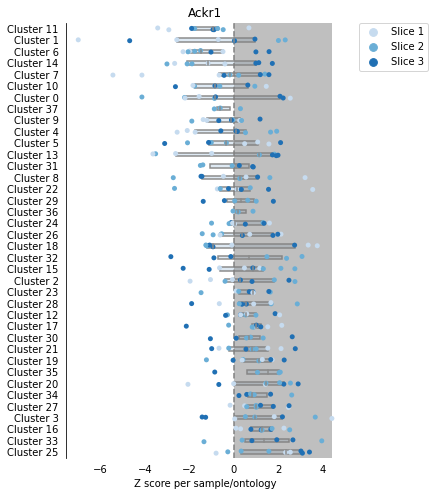

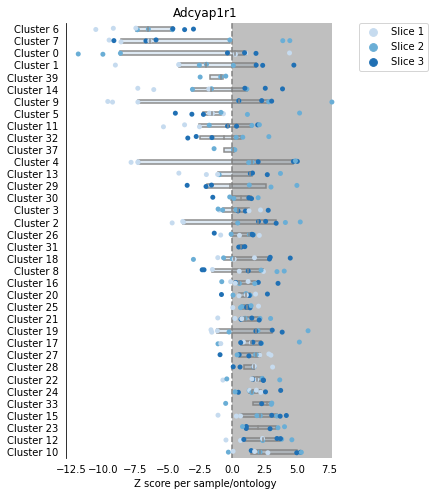

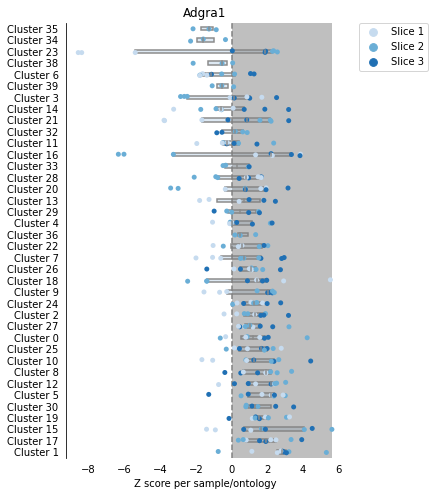

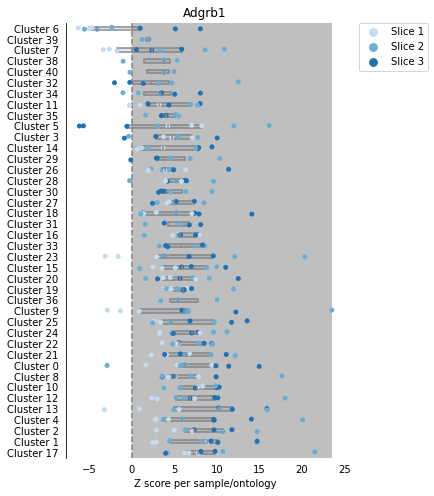

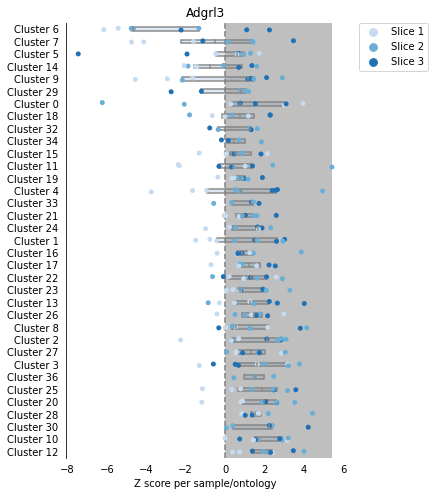

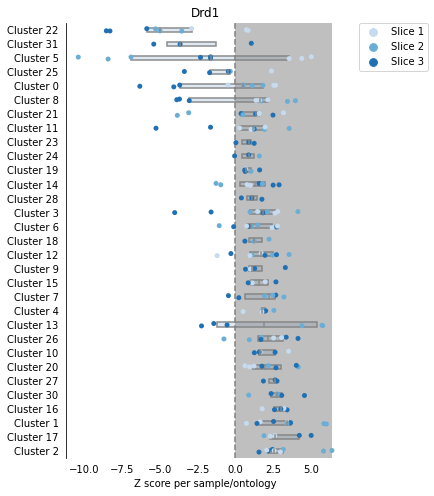

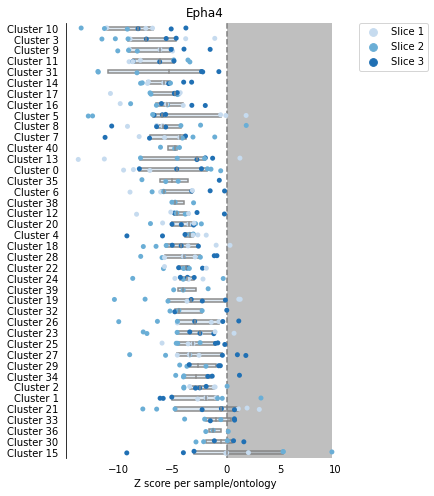

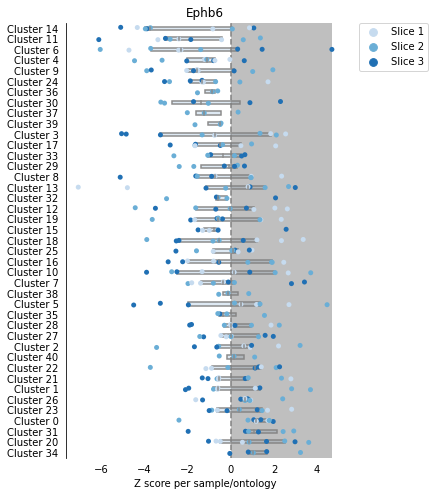

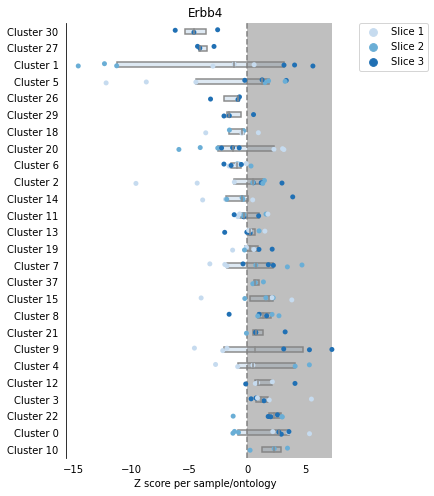

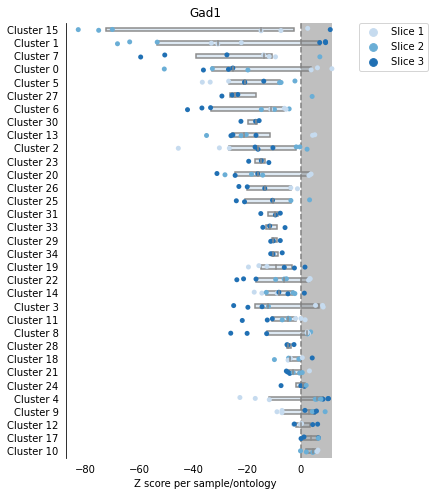

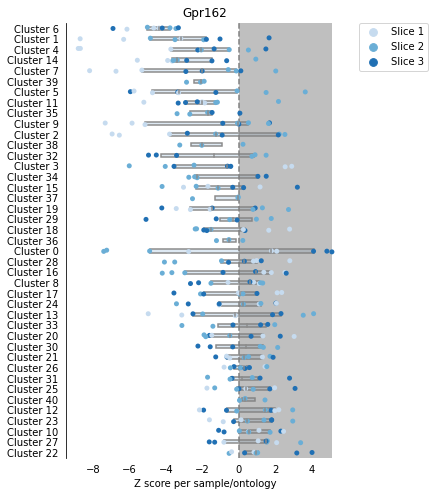

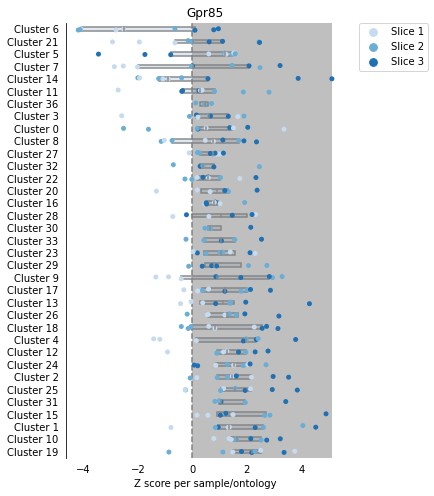

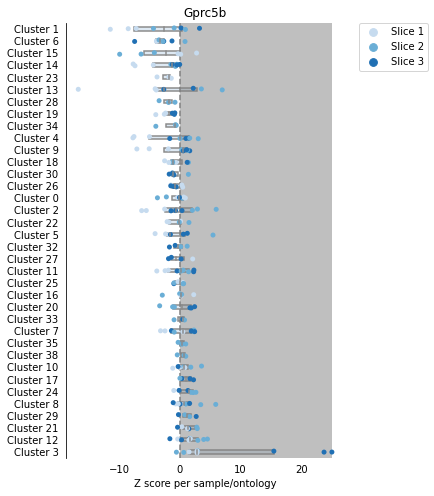

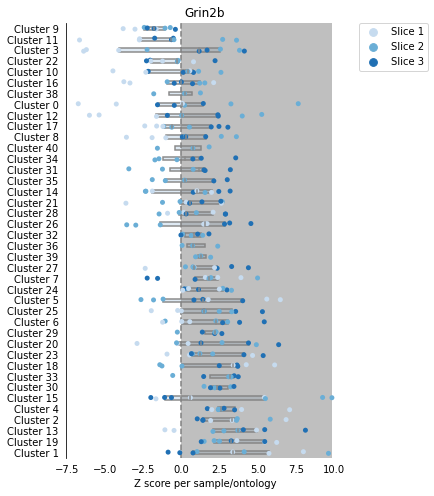

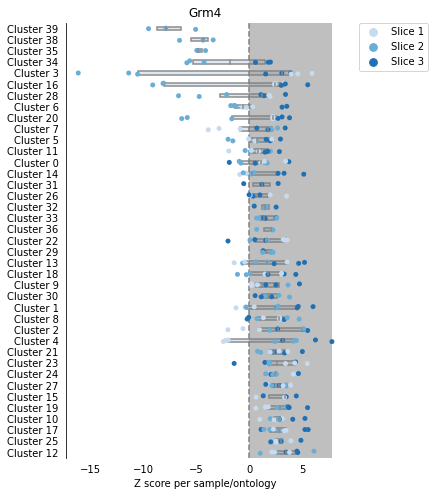

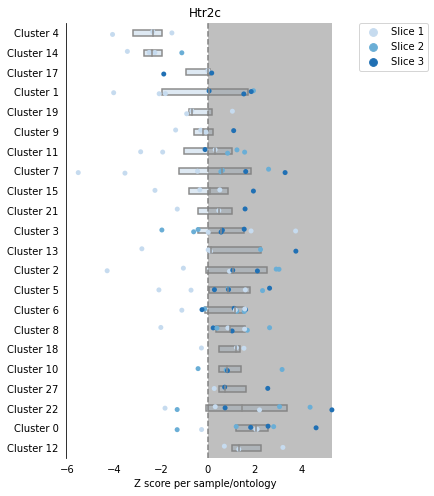

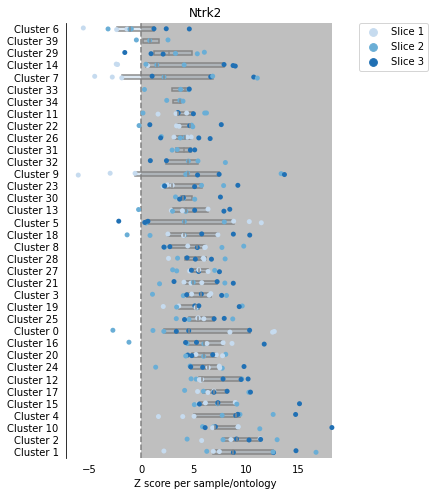

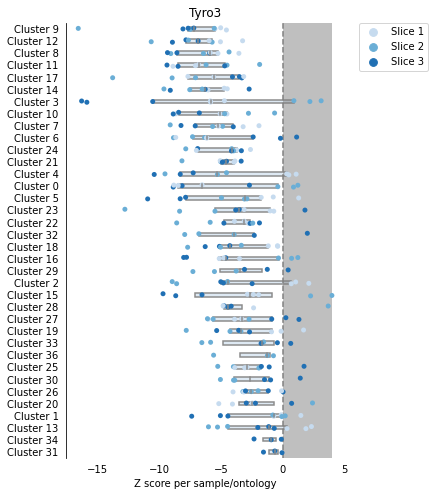

In [10]:
# simplified diagram for a single gene
genes = viz_punctate_hits.reset_index()['gene'].unique()

pdf = matplotlib.backends.backend_pdf.PdfPages('SRRS_viz_punctate_differential_genes.pdf')

for gene in genes:

    plot_df = viz_punctate_df[viz_punctate_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['ontology'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    fig = plt.figure(figsize=(5,8))
    
    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.tight_layout()
    #pdf.savefig()
    plt.close()
    
pdf.close()

In [11]:
genes = ['Drd1','Erbb4']

for gene in genes:
    plot_df = viz_punctate_df[viz_punctate_df['gene'].eq(gene)].copy()
    plot_df['annotation'] = 'Cluster '+plot_df['ontology'].astype(str)
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['slice'] = 'Slice '+plot_df['sample_id'].str[1]
    plot_df['replicate'] = 'Replicate '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('annotation')['z'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_z')

    ax = sns.stripplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        hue = 'slice',
        hue_order = sorted(plot_df['slice'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'z',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,plot_df['z'].max(),facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Z score per sample/ontology')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.tight_layout()
    plt.savefig('{}_Viz_punctate_boxplot.svg'.format(gene))
    plt.close()
    

# SeqFISH+ peripheral

In [21]:
#Getting gene/cell counts before SRRS filters are applied
import h5py
f = h5py.File('../inputs/seqfish_plus.hdf5')
print('Num SeqFISH+ genes',f['genes'])
print('Num SeqFISH+ cells',f['cell_ids'])

anns = set()

for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    anns.add(cell.attrs['annotation'])

print(anns)
f.close()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


Num SeqFISH+ genes <HDF5 dataset "genes": shape (10000,), type "|S13">
Num SeqFISH+ cells <HDF5 dataset "cell_ids": shape (913,), type "|S8">
{'NSC', 'Excitatory layer II', 'Neuroblast', 'Microglia', 'Interneurons deep', 'unannotated', 'choroid plexus', 'OPC', 'Oligodendrocytes', 'Neural progenitors', 'Astrocytes deep', 'Interneuron', 'Endothelial', 'Neuroblasts', 'Excitatory layer 5/6', 'Astrocytes superficial', 'Excitatory layer 3', 'Ependymal', 'Excitatory layer 4', 'Excitatory 5/6'}


In [2]:
seq_periph_gene_cell = pd.read_csv('../outputs/gene_cell/SeqFish_peripheral.csv')
seq_periph_gene_cell = seq_periph_gene_cell[seq_periph_gene_cell['annotation'].ne('unannotated')]

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/samples with fewer than 20 cells
seq_periph_gene_cell = seq_periph_gene_cell[seq_periph_gene_cell['num_gene_spots'].ge(5)]
seq_periph_gene_cell = seq_periph_gene_cell.groupby(['gene','annotation']).filter(lambda g: len(g) >= 10)

#Calculate z from Lyapunov CLT for each gene in each sample
gb_cols = ['gene','annotation']

seq_agg_df = seq_periph_gene_cell.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

seq_agg_df['z'] = seq_agg_df['score_sum']/np.sqrt(seq_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(seq_agg_df['z'])
seq_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    seq_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
seq_agg_df['bh_p'] = adj_p

seq_agg_df.head()

,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,Aamp,Excitatory layer 5/6,20,5.5,12498.0,0.094839,2.226461,2.419260,1.431442,0.152304,0.401552
1,Abca2,Excitatory layer 5/6,12,5.5,12103.0,-0.008420,-0.725069,1.480116,-0.595980,0.551189,0.778389
2,Abca2,Oligodendrocytes,15,13.0,3818.0,-0.193518,-2.854666,1.020810,-2.825418,0.004722,0.041245
3,Abca3,Excitatory layer 5/6,19,7.0,10596.0,-0.149283,-2.189660,2.108726,-1.507879,0.131585,0.373690
4,Abcf2,Excitatory layer 5/6,10,6.0,12465.5,-0.117780,-0.523703,1.115562,-0.495836,0.620010,0.814105


In [26]:
print('SeqFISH+ post-SRRS num cells',seq_periph_gene_cell['cell_id'].nunique())
print('SeqFISH+ post-SRRS num genes',seq_periph_gene_cell['gene'].nunique())
print('SeqFISH+ post-SRRS num onts',seq_periph_gene_cell['annotation'].nunique())

SeqFISH+ post-SRRS num cells 654
SeqFISH+ post-SRRS num genes 527
SeqFISH+ post-SRRS num onts 15


In [31]:
seq_periph_gene_cell['num_gene_spots'].min()

5

In [34]:
seq_periph_gene_ont = seq_agg_df[
    seq_agg_df['bh_p'].le(0.05) &
    seq_agg_df['num_cells'].ge(10)
].groupby('gene').filter(
    lambda g: g['med_score'].max()*g['med_score'].min() < 0
)

seq_periph_gene_ont

,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
925,Slc17a7,Excitatory 5/6,27,35.0,8076.0,-0.122964,-3.134901,0.707259,-3.727644,0.000193,0.003377
926,Slc17a7,Excitatory layer 3,60,20.5,5830.0,-0.098681,-5.329983,3.082064,-3.036023,0.002397,0.026655
929,Slc17a7,Excitatory layer II,52,11.0,4389.0,-0.128740,-6.745676,3.922363,-3.406054,0.000659,0.009619
930,Slc17a7,Interneurons deep,10,8.0,7221.5,0.426876,3.994055,0.991095,4.011960,0.000060,0.001509


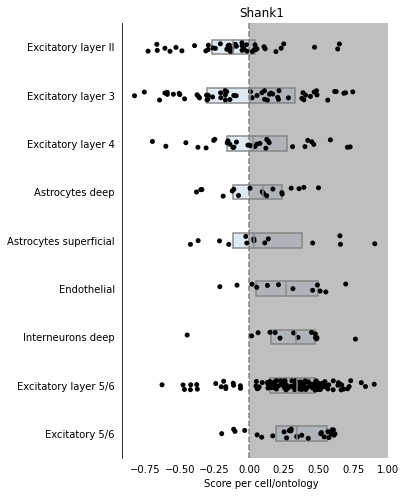

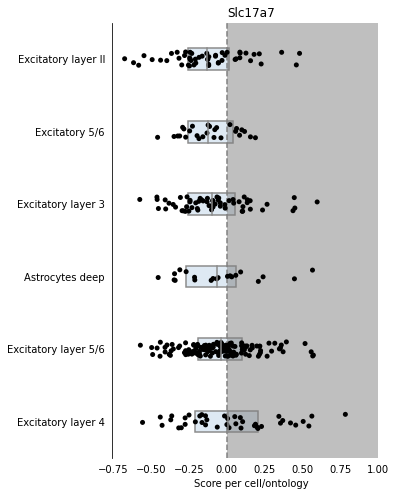

In [78]:
# simplified diagram for a single gene
genes = seq_periph_gene_ont['gene'].unique()

for gene in genes:

    plot_df = seq_periph_gene_cell[seq_periph_gene_cell['gene'].eq(gene)].copy()
    plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) > 10)
    plot_df['mean_ont_score'] = plot_df.groupby('annotation')['score'].transform('mean')
    plot_df = plot_df.sort_values('mean_ont_score')

    fig = plt.figure(figsize=(5,8))
    
    ax = sns.stripplot(
        x = 'score',
        y = 'annotation',
        orient = 'h',
        color = 'black',
        data = plot_df,
    )
    sns.boxplot(
        x = 'score',
        y = 'annotation',
        orient = 'h',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        color = '#DBE9F6',
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axvspan(0,1,facecolor='grey',alpha=0.5)
    plt.title('{}'.format(gene))
    plt.xlabel('Score per cell/ontology')
    plt.ylabel('')
    plt.show(fig)
    fig.savefig('{}_seqfish_periph_boxplot.svg'.format(gene),bbox_inches='tight')
    plt.close()
    

# SeqFISH+ radial

In [35]:
seq_radial_gene_cell = pd.read_csv('../outputs/gene_cell/SeqFish_radial.csv')
seq_radial_gene_cell = seq_radial_gene_cell[seq_radial_gene_cell['annotation'].ne('unannotated')]

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/samples with fewer than 20 cells
seq_radial_gene_cell = seq_radial_gene_cell[seq_radial_gene_cell['num_gene_spots'].ge(5)]
seq_radial_gene_cell = seq_radial_gene_cell.groupby(['gene','annotation']).filter(lambda g: len(g) >= 10)

#Calculate z from Lyapunov CLT for each gene in each sample
gb_cols = ['gene','annotation']

seq_agg_df = seq_radial_gene_cell.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

seq_agg_df['z'] = seq_agg_df['score_sum']/np.sqrt(seq_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(seq_agg_df['z'])
seq_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    seq_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
seq_agg_df['bh_p'] = adj_p

seq_agg_df.head()

,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,Aamp,Excitatory layer 5/6,20,5.5,12498.0,-0.457088,-8.061421,2.419260,-5.182870,2.184973e-07,3.006294e-07
1,Abca2,Excitatory layer 5/6,12,5.5,12103.0,-0.406128,-4.603043,1.480116,-3.783530,1.546197e-04,1.672387e-04
2,Abca2,Oligodendrocytes,15,13.0,3818.0,-0.612151,-8.758834,1.020810,-8.669095,4.355688e-18,1.652009e-17
3,Abca3,Excitatory layer 5/6,19,7.0,10596.0,-0.463476,-7.477663,2.108726,-5.149391,2.613342e-07,3.557478e-07
4,Abcf2,Excitatory layer 5/6,10,6.0,12465.5,-0.337118,-3.208065,1.115562,-3.037361,2.386594e-03,2.454722e-03


In [36]:
seq_radial_gene_ont = seq_agg_df[
    seq_agg_df['bh_p'].le(0.05) &
    seq_agg_df['num_cells'].ge(10)
].groupby('gene').filter(
    lambda g: g['med_score'].max()*g['med_score'].min() < 0
)

seq_radial_gene_ont

,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p


In [39]:
seq_agg_df[
    seq_agg_df['bh_p'].le(0.05) &
    seq_agg_df['med_score'].le(0).all()
]['gene'].nunique()

522

In [41]:
seq_agg_df[
    seq_agg_df['bh_p'].le(0.05)
]['med_score'].max()

-0.037889419028908224

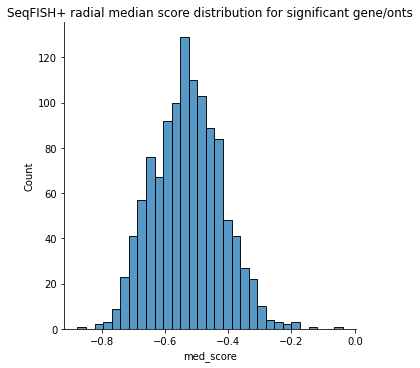

In [45]:
sns.displot(
    seq_agg_df[
        seq_agg_df['bh_p'].le(0.05)
    ]['med_score']
)
plt.title('SeqFISH+ radial median score distribution for significant gene/onts')
plt.show()
plt.close()

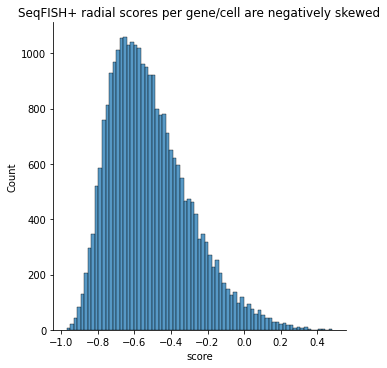

In [48]:
sns.displot(
    seq_radial_gene_cell['score']
)
plt.title('SeqFISH+ radial scores per gene/cell are negatively skewed')
plt.show()
plt.close()

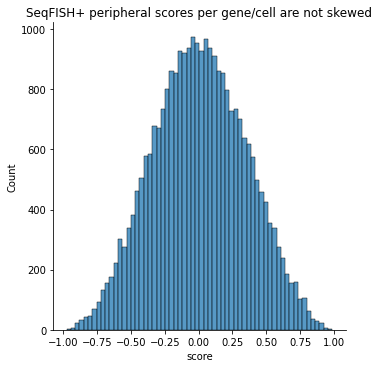

In [49]:
sns.displot(
    seq_periph_gene_cell['score']
)
plt.title('SeqFISH+ peripheral scores per gene/cell are not skewed')
plt.show()
plt.close()

# SeqFish punctate

In [13]:
seq_punctate_gene_cell = pd.read_csv('../outputs/gene_cell/Seq_punctate.csv')
seq_punctate_gene_cell = seq_punctate_gene_cell[seq_punctate_gene_cell['ontology'].ne('unannotated')]

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/samples with fewer than 20 cells
seq_punctate_gene_cell = seq_punctate_gene_cell[seq_punctate_gene_cell['num_gene_spots'].ge(5)]
seq_punctate_gene_cell = seq_punctate_gene_cell.groupby(['gene','ontology']).filter(lambda g: len(g) >= 10)

#Calculate z from Lyapunov CLT for each gene in each sample
gb_cols = ['gene','ontology']

seq_agg_df = seq_punctate_gene_cell.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

seq_agg_df['z'] = seq_agg_df['score_sum']/np.sqrt(seq_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(seq_agg_df['z'])
seq_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    seq_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
seq_agg_df['bh_p'] = adj_p

seq_agg_df.head()

,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,Aamp,Excitatory layer 5/6,20,5.5,12498.0,-0.348071,-8.269766,2.419260,-5.316820,1.055964e-07,1.383553e-07
1,Abca2,Excitatory layer 5/6,12,5.5,12103.0,-0.464452,-4.361320,1.480116,-3.584843,3.372812e-04,3.556417e-04
2,Abca2,Oligodendrocytes,15,13.0,3818.0,-0.666667,-8.972000,1.020810,-8.880077,6.681409e-19,2.377674e-18
3,Abca3,Excitatory layer 5/6,19,7.0,10596.0,-0.405959,-6.919212,2.108726,-4.764821,1.890213e-06,2.228441e-06
4,Abcf2,Excitatory layer 5/6,10,6.0,12465.5,-0.451125,-4.078492,1.115562,-3.861472,1.127060e-04,1.217901e-04


In [17]:
seq_punctate_gene_ont = seq_agg_df[
    seq_agg_df['bh_p'].le(0.05) &
    seq_agg_df['num_cells'].ge(10)
].groupby('gene').filter(
    lambda g: g['med_score'].max()*g['med_score'].min() < 0
)

seq_punctate_gene_ont

,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
